In [1]:
from analysis.utils import module_reload
module_reload('analysis')
from analysis.import_data import import_true_reco
from analysis.calc import get_kinematics
from analysis.plot_matplotlib import plot_hist, export_figures
from analysis.mem_ana import finalize_mems, plot_r, load_results
import seaborn as sns
import numpy as np
import pandas as pd
import json

/nfs/dust/ilc/user/bliewert/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = import_true_reco()
zhh = df[df['is_zhh'] == 1]
zzh = df[df['is_zzh'] == 1]
data = {
    'zhh': zhh,
    'zzh': zzh
}

repo_dir = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP'

Using cached file from /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/cache/compare_truejet_matchingreco.root_zhh_zzh.npy


In [3]:
module_reload('analysis')
from analysis.calc import get_kinematics
from analysis.cffi.Physsim import lib

In [8]:
n_samples = min(len(zhh), len(zzh))

results = {
    'zhh': {},
    'zzh': {}
}

for key, dt in data.items():
    result = {
        'zhh': [],
        'zzh': [],
    }

    for i in dt.index.values[:n_samples]:
        kin = get_kinematics(dt, True, i) # Switch to True/False
        res_zhh = lib.calculate_me(kin, mode=1)
        res_zzh = lib.calculate_me(kin, mode=0)
        
        result['zhh'].append(res_zhh)
        result['zzh'].append(res_zzh)
        
    result['is_zhh'] = dt['is_zhh'][:n_samples]
    result['event'] = dt['event'][:n_samples]
        
    results[key] = result
    
        
for key in list(results.keys()):
    results[key] = pd.DataFrame(results[key])

In [10]:
for key, result in results.items():
    result['zhh_mem'] = finalize_mems(result['zhh'], assume_zhh=True)
    result['zzh_mem'] = finalize_mems(result['zzh'], assume_zzh=True)
    result["r"] = result["zhh_mem"]/(result["zhh_mem"] + result["zzh_mem"])
    result['is_zzh'] = np.logical_not(result['is_zhh'])

In [11]:
results['zhh']['zhh']

14339    1.123449e-08
14340    5.369942e-09
14341    1.981057e-10
14342    8.231746e-10
14343    2.252700e-09
             ...     
43001    4.296797e-10
43002    1.031688e-08
43003    2.457210e-10
43004    7.643701e-09
43005    1.254715e-08
Name: zhh, Length: 28667, dtype: float64

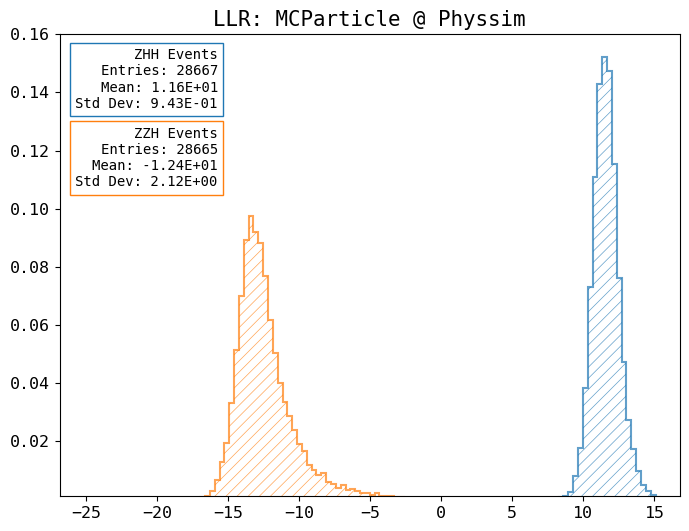

In [86]:
llr_physsim_zhh = np.log(results['zhh']['zhh']/results['zhh']['zzh'])
llr_physsim_zzh = np.log(results['zzh']['zhh']/results['zzh']['zzh'])

fig = plot_hist({ 'ZHH Events': llr_physsim_zhh, 'ZZH Events': llr_physsim_zzh }, title='LLR: MCParticle @ Physsim',
                normalize=True, text_start_x= 0.255, text_spacing_y=0.17, scientific_stats=True,
                ylim=(1e-3, 0.16));

export_figures(f'{repo_dir}/notebooks/results/3_gen_level_check_llr_physsim.pdf', [fig])

MG5 Comparison

See also mg5_comparison.ipynb

In [41]:
mg5_data = np.load('/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle_with_mg5.npy', allow_pickle=True)

events = np.concatenate((results['zzh']['event'], results['zhh']['event']))
overlap = np.isin(mg5_data[:, 1], events)
mg5_data = mg5_data[overlap]

In [50]:
df.head()

,run,event,error_code,is_zhh,is_zzh,passed_preselection,true_h1_decay_pdg,true_h2_decay_pdg,true_z2_decay_pdg,misclustering_region,...,zzh_mzzh,zzh_mh,zzh_phi,zzh_phiz,zzh_phiz1f,zzh_phiz2f,zzh_costheta,zzh_costhetaz,zzh_costhetaz1f,zzh_costhetaz2f
0,403011,10004,0,0,1,1,5,0,5,-1,...,408.567566,54.778267,2.640665,-1.305739,-0.532343,2.619891,-0.188271,0.446314,-0.969677,-0.915550
1,403011,10015,0,0,1,1,5,0,5,-1,...,453.786407,112.830429,1.968063,1.953976,-1.967962,2.088909,-0.692751,0.603589,-0.351206,-0.550601
2,403011,10028,0,0,1,1,5,0,5,-1,...,411.165436,98.699310,-1.370026,-1.139854,-0.234503,2.387021,-0.921583,0.918066,-0.983568,-0.714688
3,403011,10065,0,0,1,1,5,0,5,-1,...,406.716156,125.503708,-1.036410,-0.897460,-1.237073,2.417156,0.758035,-0.517948,0.891467,-0.418601
4,403011,10091,0,0,1,1,5,0,5,-1,...,362.977081,98.835899,2.659117,-2.296594,0.385141,2.164246,-0.752858,0.280499,-0.687565,0.601895


In [83]:
max_len = int(min(mg5_data[:, 3].sum(), mg5_data[:, 4].sum()))

zhh_indices = np.where(mg5_data[:, 3] == True)[0][:max_len]
zzh_indices = np.where(mg5_data[:, 4] == True)[0][:max_len]

llr_mg5_zhh = mg5_data[zhh_indices, -1]
llr_mg5_zzh = mg5_data[zzh_indices, -1]

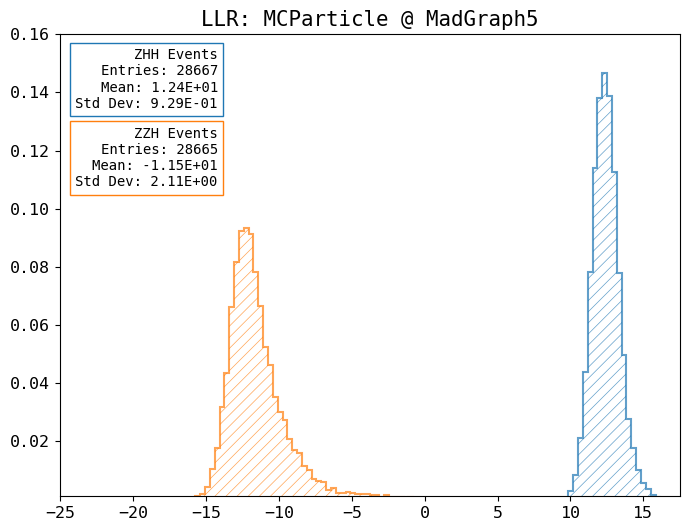

In [84]:
fig = plot_hist({ 'ZHH Events': llr_mg5_zhh, 'ZZH Events': llr_mg5_zzh }, title='LLR: MCParticle @ MadGraph5',
                normalize=True, text_start_x= 0.255, text_spacing_y=0.17, scientific_stats=True,
                ylim=(1e-3, 0.16));

export_figures(f'{repo_dir}/notebooks/results/3_gen_level_check_llr_mg5.pdf', [fig])

In [ ]:
fig = plot_hist({ 'ZHH Events': llr_physsim_zhh, 'ZZH Events': llr_physsim_zzh }, title='LLR: MCParticle @ Physsim',
                normalize=True, text_start_x= 0.255, text_spacing_y=0.17, scientific_stats=True);

export_figures(f'{repo_dir}/notebooks/results/3_gen_level_check_llr_physsim.pdf', [fig])

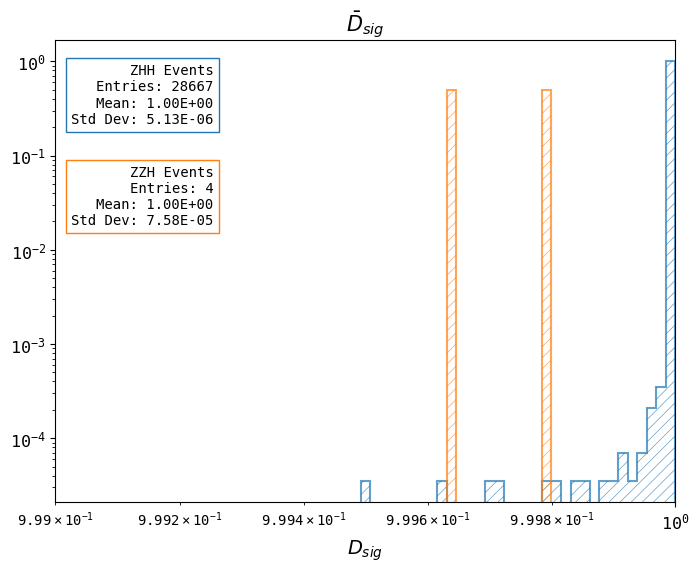

In [147]:
from analysis.utils import module_reload
module_reload('analysis')
from analysis.mem_ana import plot_r

res = {
    'zhh_r': results['zhh']['r'],
    'zzh_r': results['zzh']['r']
}

xlim = (9.99e-1, 1)
fig = plot_r(zhh_data=results['zhh']['r'], zzh_data=results['zzh']['r'],
             kwargs={ 'title': r'$\bar{D}_{sig}$', 'yscale': 'log', 'xscale': 'log', 'xlim': xlim, 'xlim_binning': xlim, 'text_start_x': .255 });

export_figures(f'{repo_dir}/notebooks/results/3_gen_level_separation_mcp_focus.pdf', [fig])

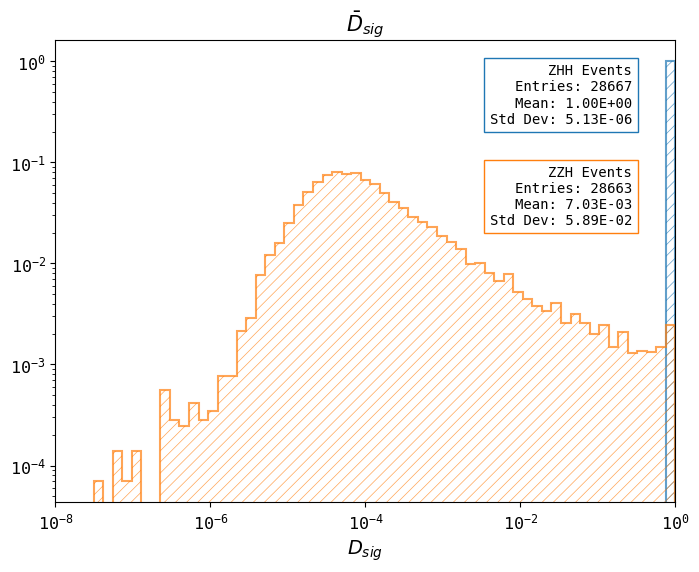

In [148]:
xlim = (1e-8, 1)
fig = plot_r(zhh_data=results['zhh']['r'], zzh_data=results['zzh']['r'], name='ZHH',
             kwargs={ 'title': r'$\bar{D}_{sig}$', 'yscale': 'log', 'xlim': xlim, 'xlim_binning': xlim });

export_figures(f'{repo_dir}/notebooks/results/3_gen_level_separation_mcp_tot.pdf', [fig])

xlim_view (1e-17, 1e-07)
xlim_view (1e-21, 1e-07)


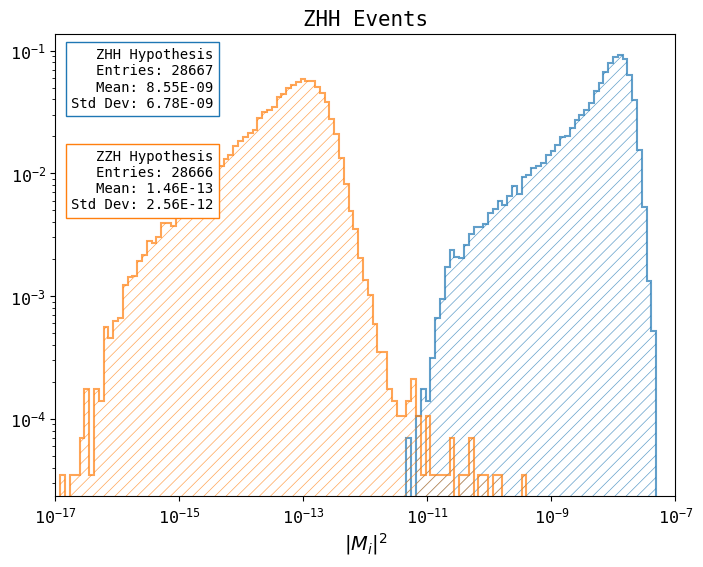

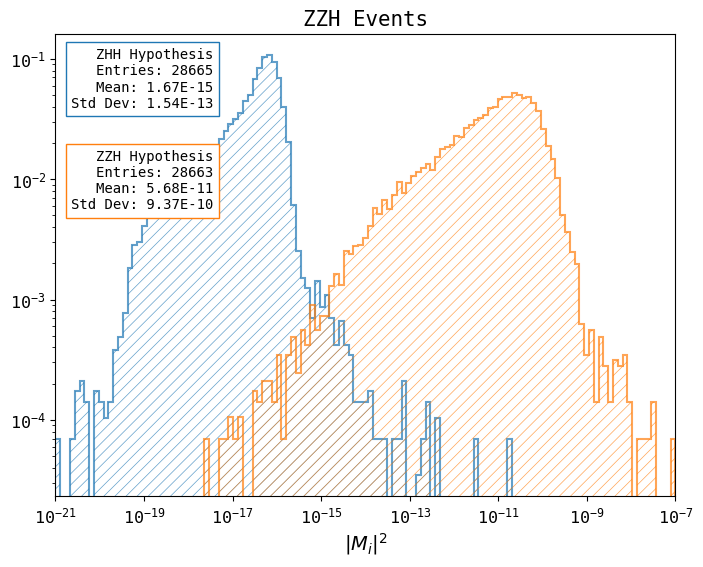

In [74]:
figures = []
limits = { 'zhh': (1e-17, 1e-7), 'zzh': (1e-21, 1e-7) }

for key, df in results.items():
    fig = plot_hist(df, x=['zhh', 'zzh'], scientific_stats=True, xscale='log', yscale='log', text_start_x=.255, xlim=limits[key], xlim_binning=limits[key],
            labels=['ZHH Hypothesis', 'ZZH Hypothesis'], xlabel=r'$|M_i|^2$', normalize=True, title=f'{key.upper()} Events');
    
    figures.append(fig)

export_figures(f'{repo_dir}/notebooks/results/3_gen_level_check_mcp.pdf', figures)

In [ ]:
df

xlim_view [8.476603069771675e-18, 4.915358196826728e-08]
xlim_view [8.259093847450947e-22, 0.000107832154217806]


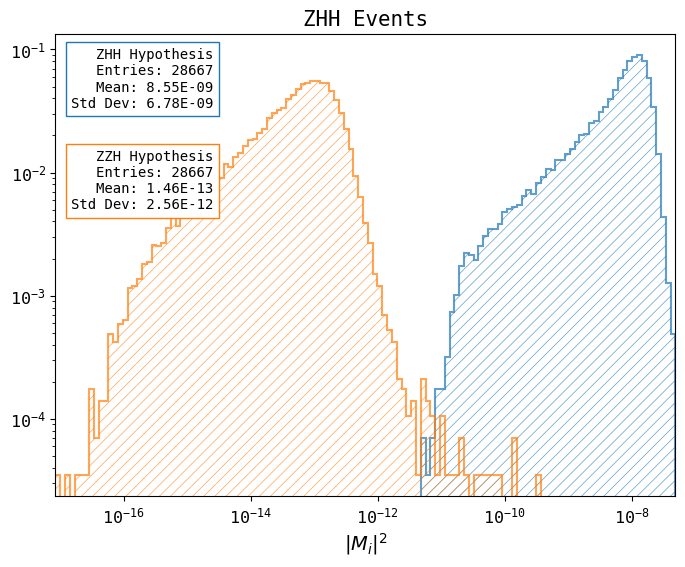

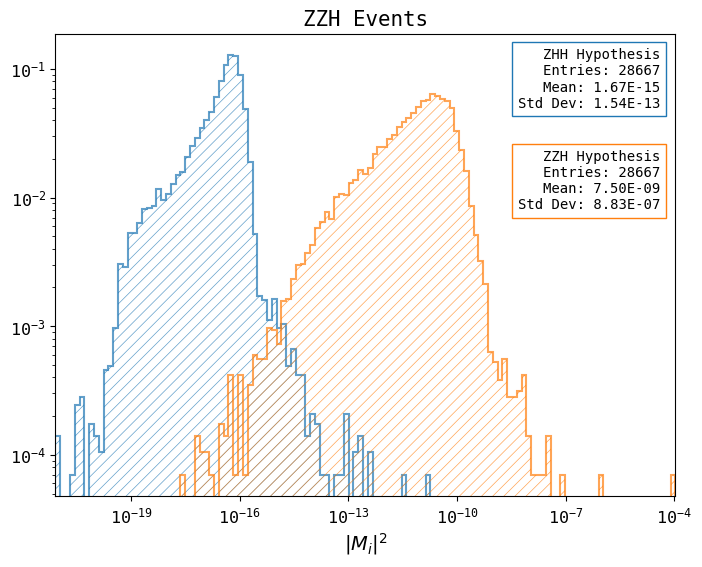

In [73]:
if False:
    figures = []
    for key, df in results.items():
        dt = df[(df['zhh'] > 0) & (df['zzh'] > 0)]
        fig = plot_hist(dt, x=['zhh', 'zzh'], scientific_stats=True, xscale='log', yscale='log', text_start_x=.255 if key == 'zhh' else 0.975,
                labels=['ZHH Hypothesis', 'ZZH Hypothesis'], xlabel=r'$|M_i|^2$', normalize=True, title=f'{key.upper()} Events');
        
        figures.append(fig)

    export_figures(f'{repo_dir}/notebooks/results/3_gen_level_check_reco.pdf', figures)

Matrix Elements with Reco kinematics

In [4]:
n_samples = min(len(zhh), len(zzh))

results = {
    'zhh': {},
    'zzh': {}
}

for key, dt in data.items():
    result = {
        'zhh': [],
        'zzh': [],
    }

    for i in dt.index.values[:n_samples]:
        kin = get_kinematics(dt, False, i) # Switch to True/False
        res_zhh = lib.calculate_me(kin, mode=1)
        res_zzh = lib.calculate_me(kin, mode=0)
        
        result['zhh'].append(res_zhh)
        result['zzh'].append(res_zzh)
        
    result['is_zhh'] = dt['is_zhh'][:n_samples]
    result['event'] = dt['event'][:n_samples]
        
    results[key] = result
    
        
for key in list(results.keys()):
    results[key] = pd.DataFrame(results[key])

In [5]:
for key, result in results.items():
    result['zhh_mem'] = finalize_mems(result['zhh'], assume_zhh=True)
    result['zzh_mem'] = finalize_mems(result['zzh'], assume_zzh=True)
    result["r"] = result["zhh_mem"]/(result["zhh_mem"] + result["zzh_mem"])
    result['is_zzh'] = np.logical_not(result['is_zhh'])
    
for key in results:
    results[key] = results[key].dropna()

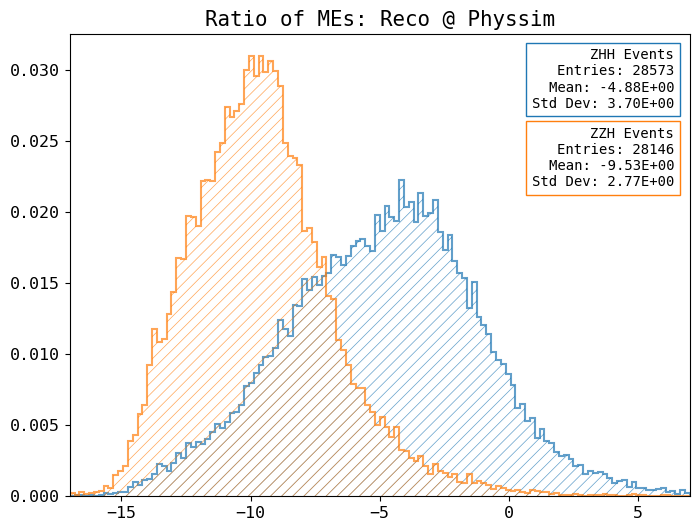

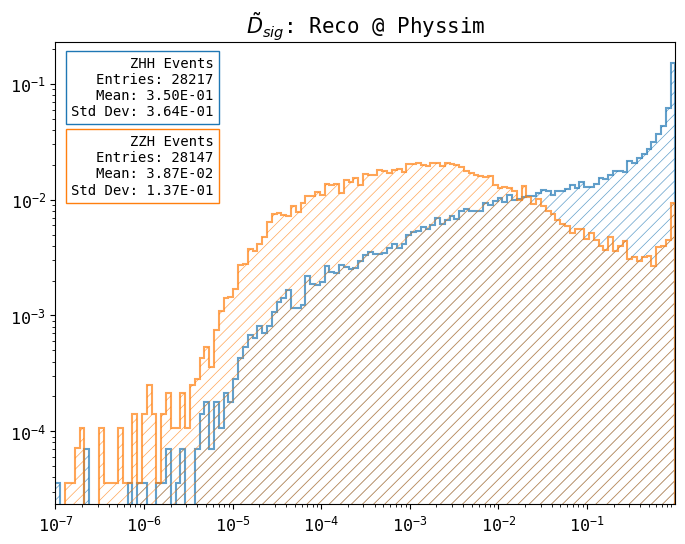

In [7]:
llr_physsim_zhh = np.log(results['zhh']['zhh']/results['zhh']['zzh'])
llr_physsim_zzh = np.log(results['zzh']['zhh']/results['zzh']['zzh'])

llr_physsim_zhh = llr_physsim_zhh[llr_physsim_zhh < np.inf]
llr_physsim_zzh = llr_physsim_zzh[llr_physsim_zzh < np.inf]

fig1 = plot_hist({ 'ZHH Events': llr_physsim_zhh, 'ZZH Events': llr_physsim_zzh }, title='Ratio of MEs: Reco @ Physsim',
                normalize=True, text_start_x= 0.975, text_spacing_y=0.17, scientific_stats=True, xlim=(-17, 7),
                );

fig2 = plot_hist({ 'ZHH Events': results['zhh']['r'], 'ZZH Events': results['zzh']['r'] }, title=r'$\tilde{D}_{sig}$: Reco @ Physsim',
                normalize=True, text_start_x= 0.255, text_spacing_y=0.17, scientific_stats=True, xscale='log', yscale='log',
                xlim=(1e-7, 0.999), );


export_figures(f'{repo_dir}/notebooks/results/3_llr_recokin_physsim.pdf', [fig1, fig2])